In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from ipywidgets import interactive
import ipywidgets as widget
from sklearn.model_selection import cross_val_score

In [2]:
loans = pd.read_csv('Data/Fraud.csv')

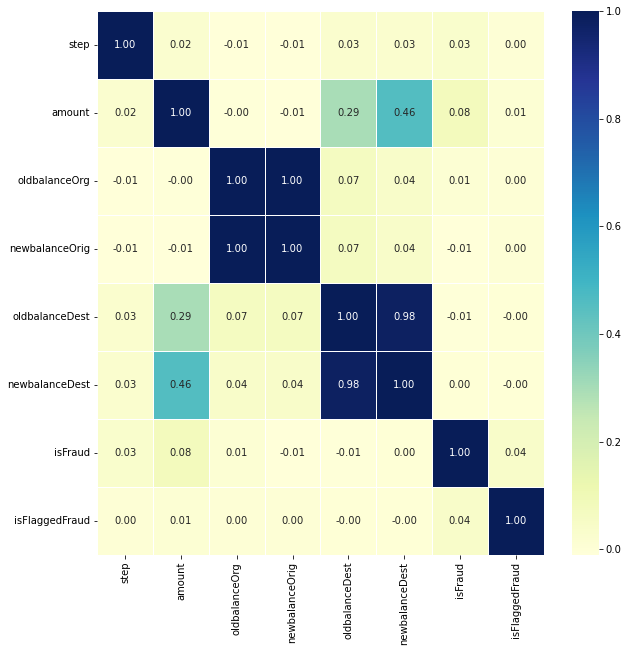

In [3]:
correlationMatrix = loans.corr() 
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(correlationMatrix,
                annot=True,
                linewidths=0.5,
                fmt='.2f',
                cmap='YlGnBu');

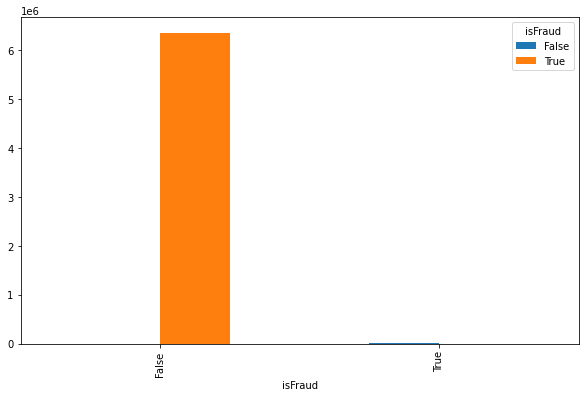

In [4]:
pd.crosstab(loans['isFraud'] == 1, loans['isFraud'] == 0).plot(kind='bar', figsize=(10,6));

In [5]:
loans.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# Too many unique values in nameOrig and nameDest to be useful, drop those columns, isFlaggedFraud isn't useful to the prediction
#of fraud, so that is dropped as well.
loans.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

In [7]:
loans.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [8]:
loans.type.value_counts() #Gets the number of each transaction type

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [9]:
loans.info() #Gets the data type for each value. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


In [10]:
#Converts the type from object into a category type.
def loan_categories(loans):
    for label, content in loans.items():
        if pd.api.types.is_string_dtype(content):
            loans[label] = content.astype('category').cat.as_ordered() 
    #This will change the data type from categorical into a number.
    for label, content in loans.items():
        if pd.api.types.is_categorical_dtype(content):
            loans[label] = pd.Categorical(content).codes
    return loans

In [11]:
loans = loan_categories(loans)
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int8   
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
dtypes: float64(5), int64(2), int8(1)
memory usage: 345.9 MB


In [12]:
x = loans.drop('isFraud', axis=1)
y = loans['isFraud']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=.2)

In [18]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(xTrain, yTrain)

RandomForestClassifier(n_jobs=-1)

In [19]:
pickle.dump(model, open('Data/loan-fraud.pkl', 'wb'))

In [ ]:
model = pickle.load(open('Data/loan-fraud.pkl', 'rb')) #To load the model in the future so I don't have to re train every time

In [20]:
yPreds = model.predict(xTest)

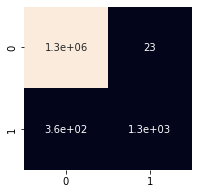

In [21]:
#Plot a confusion matrix
fig, ax = plt.subplots(figsize=(3,3))
ax=sns.heatmap(confusion_matrix(yTest, yPreds),
               annot=True,
               cbar=False)

In [22]:
featureImportance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

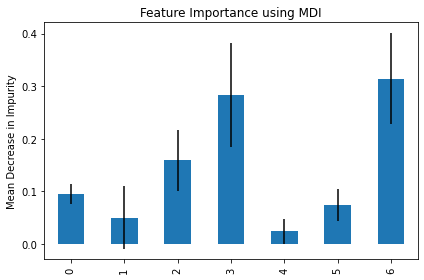

In [23]:
forestImportances = pd.Series(featureImportance)

fig, ax = plt.subplots()
forestImportances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature Importance using MDI')
ax.set_ylabel('Mean Decrease in Impurity')
fig.tight_layout()

In [24]:
from IPython.display import display

#Creates a bar chart to show the probability of the transaction being fraud or not
def bar_chart(prob):
    probabilities = {'Not Fraud': prob[0],
                    'Fraud': prob[1]}
    fig, ax = plt.subplots()
    ax.set_title('Probability of Fraud')
    ax.set_ylabel('Percent Probability')
    ax.bar(probabilities.keys(), probabilities.values(), width=.5);


   

#Takes the values from the widgets and displays the prediction of fraud and the bar chart of the likelihood
def prediction_function(step, typeTransaction, amount, oldBalance, newBalance, oldBalanceDest, newBalanceDest):
    data = [[step, typeTransaction, amount, oldBalance, newBalance, oldBalanceDest, newBalanceDest]]
    features = pd.DataFrame(data, columns=['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                                           'oldbalanceDest', 'newbalanceDest'])
    features = loan_categories(features)
    yPreds = model.predict(features)
    probability = model.predict_proba(features)
    
    probability = probability * 100  
    bar_chart(probability[0])

    displayText = ''
    if yPreds[0] == 1:
        displayText = 'Fraud Likely'
    else:
        displayText = 'Fraud Unlikely'
    print(displayText)

In [30]:
dropdownOptions = ['CASH-IN', 'CASH-OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']
style = {'description_width': 'initial'}
dis = interactive(prediction_function,
      step = widget.IntText(value=1,description='Steps in hours:', style=style),
      typeTransaction = widget.Dropdown(options=dropdownOptions, description='Type of Transaction', style=style), 
      amount = widget.FloatText(value = 0.0,description='Amount of loan:',style=style),
      oldBalance = widget.FloatText(value = 0.0,description='Original Balance Before:', style=style),
      newBalance = widget.FloatText(value = 0.0,description='Original Balance After:', style=style),
      oldBalanceDest = widget.FloatText(value = 0.0, description='Destination Balance Before:', style=style),
      newBalanceDest = widget.FloatText(value = 0.0,description='Destination Balance After:', style=style)
      )
display(dis)

interactive(children=(IntText(value=1, description='Steps in hours:', style=DescriptionStyle(description_width…